# Disaggregation of appliances from generated load profiles

## Open questions:
- Does an appliance count as 'on' if it is active at _any_ time within a given window?

In [1]:
# General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.optimizers import Adam

%matplotlib inline

In [2]:
df = pd.read_csv("data/data_reduced.csv", index_col=0)
df

,Electricity.Timestep,Time,Stove,Coffee_machine,Microwave,Dishwasher,Washing_machine,Target
0,0,2021-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2021-01-01 00:00:01,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2021-01-01 00:00:02,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2021-01-01 00:00:03,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2021-01-01 00:00:04,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
172795,172795,2021-01-02 23:59:55,0.0,0.0,0.0,0.0,0.0,0.0
172796,172796,2021-01-02 23:59:56,0.0,0.0,0.0,0.0,0.0,0.0
172797,172797,2021-01-02 23:59:57,0.0,0.0,0.0,0.0,0.0,0.0
172798,172798,2021-01-02 23:59:58,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
appliances = ["Stove", "Coffee_machine", "Microwave", "Dishwasher", "Washing_machine"]

<AxesSubplot:>

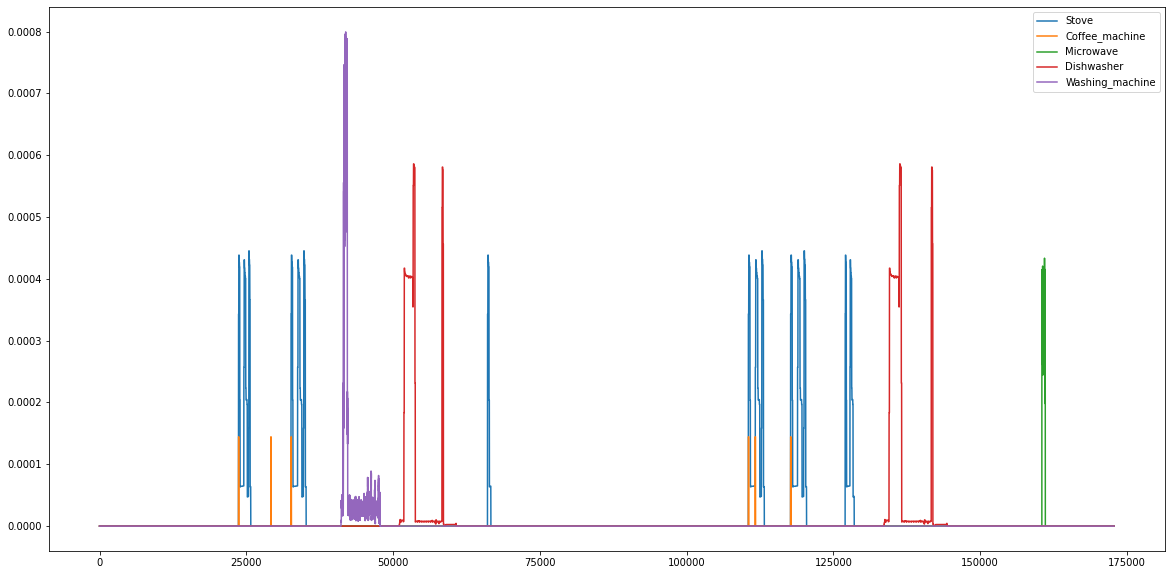

In [4]:
df.plot(y=appliances, figsize=(20,10))

<AxesSubplot:>

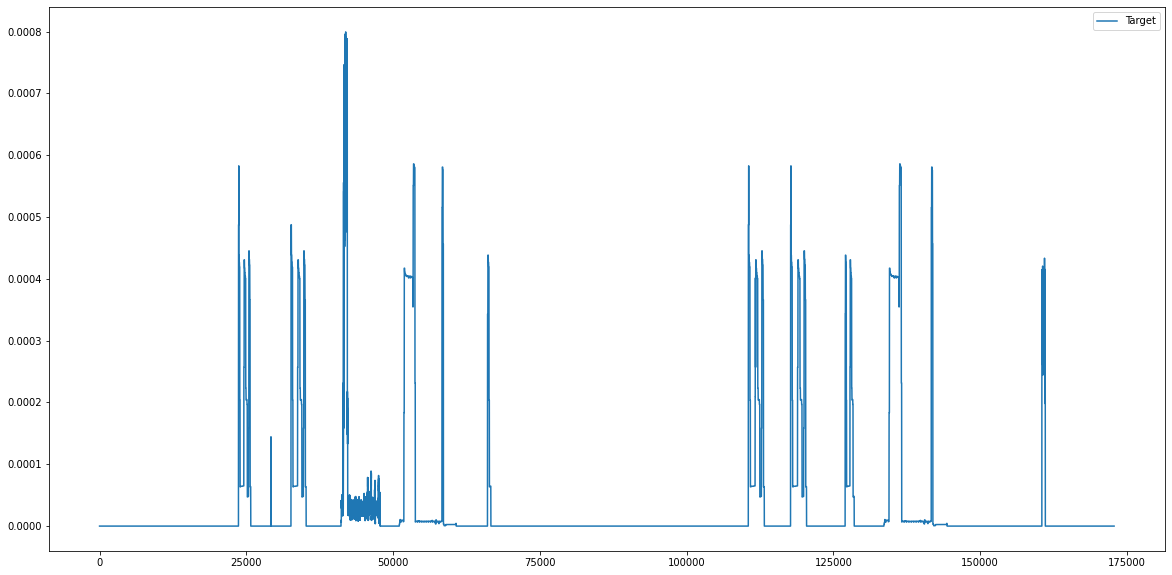

In [5]:
df.plot(y=["Target"], figsize=(20,10))

## Create rolling window

In [6]:
# first entry
df.iloc[[23659]]

,Electricity.Timestep,Time,Stove,Coffee_machine,Microwave,Dishwasher,Washing_machine,Target
23659,23659,2021-01-01 06:34:19,0.000343,0.000144,0.0,0.0,0.0,0.000488


In [7]:
"""
returns the label vector
a device is 'on' if at any time within the timeframe it is running
"""
def create_label_vector(df, start, end):
    target_vector = np.zeros(len(appliances))
    for i in range(start, end):
        for idx, x in enumerate(df.columns):
            if x not in appliances:
                continue
            else:
                if df[x][i] > 0:
                    target_vector[appliances.index(x)] = 1
    return target_vector

In [8]:
def create_rolling(df, arr, window_size, step, start=0, drop_zero=True):
    windows = list()
    targets = list()
    arr_length = len(arr)
    
    if window_size >= arr_length:
        raise Exception("Window size is larger than given array")
    
    while start < arr_length - 1:
        end = start + window_size
        current_window = arr[start:end]
        if len(current_window) == window_size:
            if drop_zero and not all(entries == 0 for entries in current_window):
                targets.append(create_label_vector(df, start, end))
                windows.append(current_window)
        start = start + step
        
    return windows, targets

### Test

In [9]:
arr = [0,1,2,3,4,5,6,7,8,9]
window_size = 60
step = 1

# Convert time series data to windowed data frame

In [40]:
def create_timeseries_dataframe(data, window_size):
    windows, targets = create_rolling(df=data, arr=list(data["Target"]), window_size=window_size, step=1)
    column_names_samples = [f"sample_{i}" for i in list(range(window_size))]
    column_names = column_names_samples + appliances
    merged = []
    for i in range(len(windows)):
        merged.append(list(np.array(windows[i])) + list(np.array(targets[i])))
    df_timeseries = pd.DataFrame(data=merged, columns=column_names)
    return df_timeseries

In [41]:
df_timeseries = create_timeseries_dataframe(df, window_size)
df_timeseries[appliances] = df_timeseries[appliances].astype(int)
df_timeseries

,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,...,sample_55,sample_56,sample_57,sample_58,sample_59,Stove,Coffee_machine,Microwave,Dishwasher,Washing_machine
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000488,1,1,0,0,0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000488,0.000488,1,1,0,0,0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000488,0.000488,0.000488,1,1,0,0,0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000488,0.000488,0.000488,0.000488,1,1,0,0,0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000488,0.000488,0.000488,0.000488,0.000488,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40613,0.000315,0.000388,0.000369,0.000254,0.000283,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,0,0
40614,0.000388,0.000369,0.000254,0.000283,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,0,0
40615,0.000369,0.000254,0.000283,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,0,0
40616,0.000254,0.000283,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,0,0


# Train-test split

In [112]:
samples = [x for i,x in enumerate(df_timeseries.columns) if x not in appliances]
X = df_timeseries.loc[:, samples]
y = df_timeseries.loc[:, appliances]

In [147]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [148]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42, shuffle=False)

# Modeling

In [115]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [116]:
X_train.shape

(27619, 60)

In [117]:
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [118]:
EPOCHS = 20
BATCH_SIZE = 32

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

In [119]:
def create_model():
    input_layer = keras.layers.Input(shape=(window_size, 1))
    
    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(len(appliances), activation="sigmoid")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [120]:
model = create_model()
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [121]:
loss_fn = tf.keras.losses.BinaryCrossentropy()

In [122]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [123]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS)

Epoch 1/20
864/864 [==============================] - 9s 9ms/step - loss: 0.2461 - accuracy: 0.7795 - val_loss: 97.3499 - val_accuracy: 0.6816 - lr: 0.0010
Epoch 2/20
864/864 [==============================] - 8s 10ms/step - loss: 0.1887 - accuracy: 0.8390 - val_loss: 315.0172 - val_accuracy: 0.3184 - lr: 0.0010
Epoch 3/20
864/864 [==============================] - 8s 9ms/step - loss: 0.1520 - accuracy: 0.8715 - val_loss: 2509.0972 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/20
864/864 [==============================] - 8s 10ms/step - loss: 0.1253 - accuracy: 0.8987 - val_loss: 1046.7505 - val_accuracy: 0.3184 - lr: 0.0010
Epoch 5/20
864/864 [==============================] - 8s 10ms/step - loss: 0.1086 - accuracy: 0.9094 - val_loss: 237.5796 - val_accuracy: 0.3184 - lr: 0.0010
Epoch 6/20
864/864 [==============================] - 8s 9ms/step - loss: 0.0983 - accuracy: 0.9155 - val_loss: 735.9042 - val_accuracy: 0.3184 - lr: 0.0010
Epoch 7/20
864/864 [==============================

In [146]:
y_test

,Stove,Coffee_machine,Microwave,Dishwasher,Washing_machine
32494,0,0,0,1,0
32495,0,0,0,1,0
32496,0,0,0,1,0
32497,0,0,0,1,0
32498,0,0,0,1,0
...,...,...,...,...,...
40613,0,0,1,0,0
40614,0,0,1,0,0
40615,0,0,1,0,0
40616,0,0,1,0,0


In [153]:
model.evaluate(X_train, y_train)

864/864 [==============================] - 4s 4ms/step - loss: 5858.1079 - accuracy: 0.3532


[5858.10791015625, 0.3531988859176636]

In [151]:
model.predict(X_train.iloc[0])

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0.

In [124]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

254/254 [==============================] - 1s 3ms/step - loss: 2310.6548 - accuracy: 0.9218
Test accuracy 0.9218365550041199
Test loss 2310.65478515625


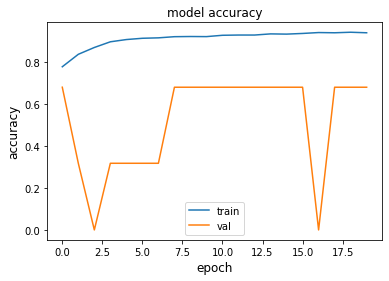

In [125]:
metric = "accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [127]:
y_val

,Stove,Coffee_machine,Microwave,Dishwasher,Washing_machine
27619,1,0,0,0,0
27620,1,0,0,0,0
27621,1,0,0,0,0
27622,1,0,0,0,0
27623,1,0,0,0,0
...,...,...,...,...,...
32489,0,0,0,1,0
32490,0,0,0,1,0
32491,0,0,0,1,0
32492,0,0,0,1,0
